In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ipywidgets import interact, IntSlider
import ipyplot
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-02-02 15:15:23.458374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
###############################
# 1. Data Paths and Retrieval #
###############################

# Unlabeled dataset (to cluster later)
DATASET_ROOT_UNLABELED = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/jaffe_dataset_unsorted'

# Labeled dataset (for fine-tuning; assumed to follow a directory-per-class structure)
DATASET_ROOT_LABELED = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/jaffe_dataset'

IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']

def get_image_paths(root_dir, extensions):
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob(os.path.join(root_dir, '**', ext), recursive=True))
    return image_paths

unlabeled_image_paths = get_image_paths(DATASET_ROOT_UNLABELED, IMAGE_EXTENSIONS)
print(f"Found {len(unlabeled_image_paths)} unlabeled images.")


Found 213 unlabeled images.


In [3]:
######################################
# 2. ROI Extraction and Preprocessing #
######################################
def extract_face_roi(image_path):
    """
    Loads the image in grayscale, crops the central region as a crude face ROI,
    resizes it to 64x64, and normalizes pixel values.
    (For better results, consider using a proper face detector.)
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    # Crop central 60% of the image (placeholder for face detection)
    crop_h, crop_w = int(0.6 * h), int(0.6 * w)
    start_h = (h - crop_h) // 2
    start_w = (w - crop_w) // 2
    roi = img[start_h:start_h + crop_h, start_w:start_w + crop_w]
    roi_resized = cv2.resize(roi, (64, 64))
    return roi_resized.astype(np.float32) / 255.0

def preprocess_image(path):
    """
    Preprocess an image file: extract face ROI and expand dimensions to create
    a (64,64,1) tensor.
    """
    try:
        processed = extract_face_roi(path)
        if processed is None:
            raise ValueError("Image could not be loaded")
        # Expand dims to add channel dimension
        return np.expand_dims(processed, axis=-1)
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")
        return None

In [4]:
####################################
# 3. Data Augmentation for Fine-Tuning #
####################################
# Use ImageDataGenerator to augment the labeled dataset.
BATCH_SIZE = 32
img_height, img_width = 64, 64

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # Split labeled data for validation.
)

train_generator = train_datagen.flow_from_directory(
    DATASET_ROOT_LABELED,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # labels as integers
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_ROOT_LABELED,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 172 images belonging to 7 classes.
Found 41 images belonging to 7 classes.


/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


In [5]:
#############################################
# 4. Load Pretrained Mini-Xception Model  #
#############################################
def get_emotion_model():
    """
    Loads the pre-trained Mini-Xception model (trained on FER-2013).
    Download a model such as 'fer2013_mini_XCEPTION.hdf5' from:
    https://github.com/oarriaga/face_classification/tree/master/trained_models/emotion_models
    and update the path below.
    """
    model_path = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer2013_mini_XCEPTION.99-0.65.hdf5'  # Update with your model file path
    # Load without compiling to avoid optimizer mismatches.
    return tf.keras.models.load_model(model_path, compile=False)

emotion_model = get_emotion_model()
# Remove final classification layer; use the second-to-last layer as feature extractor.
base_model = tf.keras.Model(inputs=emotion_model.input, outputs=emotion_model.layers[-2].output)

In [6]:
#####################################
# 5. Fine-Tune the Emotion Model    #
#####################################
# Fine-tune on your labeled dataset so the model better distinguishes emotions.
num_emotions = len(train_generator.class_indices)

base_model.trainable = True
# Remove the GlobalAveragePooling2D since base_model already outputs a feature vector.
fine_tune_model = models.Sequential([
    base_model,  # base_model outputs a vector (None, 7) in this case.
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_emotions, activation='softmax')
])

fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Fine-tune the model (adjust epochs as needed).
fine_tune_model.fit(train_generator, validation_data=validation_generator, epochs=10)

/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.1808 - loss: 2.5666 - val_accuracy: 0.1463 - val_loss: 2.3927
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1282 - loss: 2.4232 - val_accuracy: 0.1463 - val_loss: 2.2559
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.2026 - loss: 2.3878 - val_accuracy: 0.1463 - val_loss: 2.2751
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1378 - loss: 2.2946 - val_accuracy: 0.1463 - val_loss: 2.2421
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.1101 - loss: 2.2570 - val_accuracy: 0.1463 - val_loss: 2.2074
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.1306 - loss: 2.2351 - val_accuracy: 0.1707 - val_loss: 2.1550
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.1531 - loss: 2.2068 - val_accuracy: 0.1220 - val_loss: 2.1466
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.2090 - loss: 2.1012 - val_accuracy: 0.1463 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1392 - loss: 2.0384 
Validation Accuracy: 14.63%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.14      0.83      0.24         6
     disgust       0.67      0.40      0.50         5
        fear       0.00      0.00      0.00         6
   happiness       0.00      0.00      0.00         6
     neutral       0.00      0.00      0.00         6
     sadness       0.00      0.00      0.00         6
    surprise       0.00      0.00      0.00         6

    accuracy                           0.17        41
   macro avg       0.12      0.18      0.11        41
weighted avg       0.10      0.17      0.10        41

Confusion Matrix:
[[5 0 0 0 0 1 0]
 [3 2 0 0 0 0 0]
 [6 0 0 0 0 0 0]
 [6 0 0 0 0 0 0]
 [4 1 0 0 0 1 0]
 [6 0 0 0 0 0 0]
 [6 0 0 0 0 0 0]]


/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

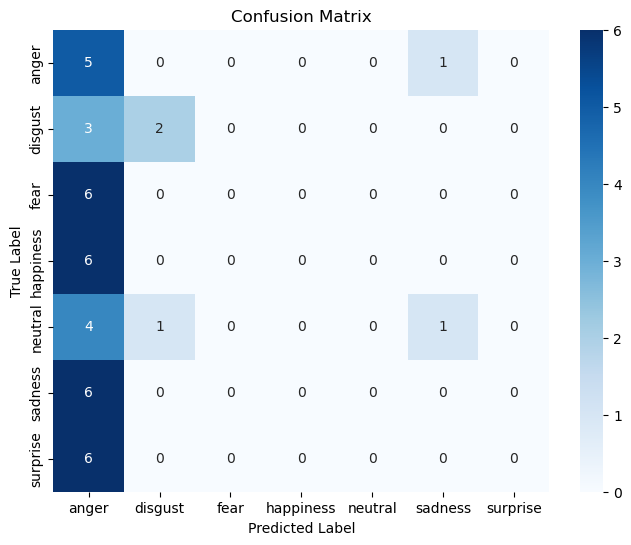

In [7]:
############################################
# 6. Evaluate the Fine-Tuned Model         #
############################################
# Evaluate the model on the validation set.
val_loss, val_accuracy = fine_tune_model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2%}")

# Generate predictions on the validation set.
val_preds = fine_tune_model.predict(validation_generator)
# Convert predicted probabilities to class indices.
val_pred_classes = np.argmax(val_preds, axis=1)

# Retrieve true labels from the validation generator.
val_true = validation_generator.classes

# Create a classification report.
target_names = list(validation_generator.class_indices.keys())
report = classification_report(val_true, val_pred_classes, target_names=target_names)
print("Classification Report:")
print(report)

# Create a confusion matrix.
cm = confusion_matrix(val_true, val_pred_classes)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
##############################################################
# 6. Feature Extraction from Unlabeled Data for Clustering   #
##############################################################
def extract_features(image_paths, batch_size=32):
    features = []
    valid_paths = []  # Save paths for which preprocessing succeeded.
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        for p in batch_paths:
            img = preprocess_image(p)
            if img is not None:
                batch_images.append(img)
                valid_paths.append(p)
        if batch_images:
            batch_images = np.array(batch_images)
            # Use the fine-tuned base_model to extract features.
            batch_features = base_model.predict(batch_images)
            features.extend(batch_features)
    return np.array(features), valid_paths

features, valid_unlabeled_paths = extract_features(unlabeled_image_paths)
print(f"Extracted features for {features.shape[0]} images.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Extracted features for 213 images.


In [9]:
#########################################################
# 7. Feature Normalization and Dimensionality Reduction #
#########################################################
# Normalize features to improve clustering.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.reshape(features.shape[0], -1))

# Use UMAP for dimensionality reduction.
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(features_scaled)

/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/opt/anaconda3/envs/ml_expressions/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


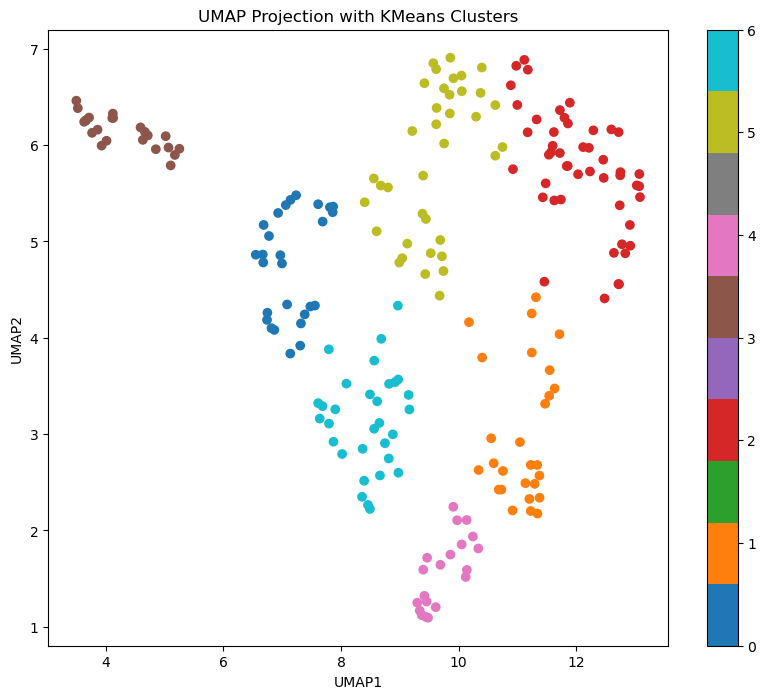

In [10]:
####################################
# 8. Clustering with KMeans         #
####################################
# Cluster into a number of clusters equal to the number of emotion classes.
n_clusters = num_emotions
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(umap_features)

# Visualize clusters.
plt.figure(figsize=(10, 8))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=clusters, cmap='tab10')
plt.title('UMAP Projection with KMeans Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.show()

In [11]:
######################################################
# 9. Interactive Cluster Review (Optional)         #
######################################################
def review_cluster(image_paths, clusters, cluster_id):
    # Display up to 50 images from the selected cluster.
    cluster_images = [p for p, c in zip(valid_unlabeled_paths, clusters) if c == cluster_id]
    ipyplot.plot_images(cluster_images[:50], max_images=50, img_width=150, force_b64=True)

@interact(cluster=IntSlider(min=0, max=n_clusters - 1, step=1))
def show_cluster(cluster):
    review_cluster(valid_unlabeled_paths, clusters, cluster)

# End of comprehensive code block.


interactive(children=(IntSlider(value=0, description='cluster', max=6), Output()), _dom_classes=('widget-inter…